In [1]:
###Importamos las bibliotecas necesarias:
##Importamos Pandas para trabajar con DataFrames
import pandas as pd

##Importamos la biblioteca itertools para tener herramientas de iteración sobre diferentes conjuntos
import itertools

##Importamos Numpy para incluir más funciones matematicas
import numpy as np

##Importamos la función rankdata de scipy para poder asignar rangos en el test de wilcoxon
from scipy.stats import rankdata

##Importamos MatPlotLib para realizar representaciones
import matplotlib.pyplot as plt
from matplotlib import gridspec #Es un paquete de matplotlib que permite realizar figuras de varias subfiguras

##Importamos la función display de la biblioteca IPython.display, que permite mostrar contenido de manera más enriquecida
from IPython.display import display

##Importamos el módulo time para poder medir el tiempo de ejecución del código
import time

##Immportamos el generador de números aleatorios
import random

In [2]:
#Definimos una función para representar de manera cómoda dos señales diferentes aleatorias en un mismo grafico, que provengan del mismo conjunto de datos
def plot_pulsos(data):
    #Generar dos números enteros aleatorios entre 1 y 1708
    n_random = random.randint(1, 1708)
    m_random = random.randint(1, 1708)
    
    #Representación de las señales en un plot
    plt.figure(figsize = (10, 5))
    plt.plot(data.iloc[n_random], label = "Señal 1", color = "blue")
    plt.plot(data.iloc[m_random], label = "Señal 2", color = "red")
    plt.title('Señal')
    plt.xticks([])
    plt.ylabel('Valor')
    plt.show()

In [3]:
#Función para normalizar las señales. Proporciona dos opciones: 1 para normalizar a [0,1] y 2 para normalizar respecto al valor máximo
#Por defecto normaliza a escala [0,1]
def normalizacion(df, tipo = 1):
    #Normalización [0,1]
    if tipo == 1:
        maximos_fila = df.max(axis = 1).to_numpy() #Extraemos el valor máximo de las filas
        minimos_fila = df.min(axis = 1).to_numpy() #Extraemos el valor mínimo de las filas
        df = (df - minimos_fila[:, None])/(maximos_fila[:, None] - minimos_fila[:, None]) #Normalizamos los valores del Dataframe
        return df
    
    #Normalización respecto al máximo
    if tipo == 2:
        maximos_fila = df.max(axis = 1).to_numpy() #Extraemos el valor máximos de las filas
        df = df/maximos_fila[:, None] #Dividimos cada fila por su máximo
        return df

In [4]:
##Función para generar las posibles combinacinoes de pares de pulsos sin repetición a partir de un Dataframe con una combinación de pulsos.
#Va a devolver la lista de pares de índices o la lista de índices y el Dataframe combinado.
def paired_pulses(df, return_df = False):
    #Calculamos las posibles combinaciones de pulsos mediante los índices
    paired_index = list(itertools.combinations(df.index, 2))

    #La función devuelve o la lista de índices, o la lista de índices y el dataframe con las combinaciones de pares de pulsos, 
    #dependiendo de la elección que se haya elegido al llamar a la función.
    
    if return_df == False:
        return paired_index #Devolvemos solo los pares de indices
    
    if return_df == True:
        #Generamos un nuevo Dataframe que contenga las posibles combinaciones de pares de pulsos
        #Preparamos una lista donde vamos a almacenar cada par de pulsos concatenados
        new_rows = []

        #Iteramos sobre las posibles combinaciones de pares de pulsos (pares de índices)
        for index1, index2 in paired_index:
            #Extraemos los pulsos asociados a cada uno de los índices
            pulse1 = df.loc[index1].values
            pulse2 = df.loc[index2].values

            #Concatenamos los valores de ambos pulsos en una sola fila
            concatenated_pulses = [index1, index2] + list(np.concatenate([pulse1, pulse2]))

            #Agregamos el pulso concatenado a la lista de filas de las combinaciones de pulsos
            new_rows.append(concatenated_pulses)

        #Convertimos en un Dataframe la lista de pares de pulsos generada
        columns = ['id_1', 'id_2'] + list(range(df.shape[1] * 2))
        combined_df = pd.DataFrame(new_rows, columns=columns)

        #Devolvemos el Dataframe generado y la lista de índices
        return paired_index, combined_df

In [20]:
##Creamos una función que recibe dos pulsos como entrada y los alinea el 10% de la altura máxima ("down") o al 90% de la altura máxima ("up") segun se indique en el argumento de la función.
#Devuelve como salida los pulsos alineados.
#Tener en cuenta que los pulsos deben estar normalizados a [0,1]
def alinear(pulso1, pulso2):
    #Definimos los valores para los cuales se alcanza el 90% y el 10% del máximo. Que al estar normalizados en [0,1] son 0.9 y 0.1 respectivamente.
    T90 = 0.9 #90% de la altura del pulso
    T10 = 0.1 #10% de la altura del pulso

    #Calculamos la posición en la que el pulso 1 alcanza el 90% en subida
    for i in pulso1.index.astype(int):
        if pulso1.iloc[i] > T90:
            i90_1 = i - 1
            break
        else: 
            continue
    
    #Calculamos la posición en la que el pulso 1 alcanza el 10% en bajada
    for i in pulso1.index.astype(int):
        if pulso1.iloc[len(pulso2.index.astype(int)) - i] < T10:
            i10_1 = len(pulso2.index.astype(int)) - i + 1
            break
        else:
            continue
    
    #Calculamos la posición en la que el pulso 2 alcanza el 90% en subida
    for i in pulso2.index.astype(int):
        if pulso2.iloc[i] > T90:
            i90_2 = i - 1
            break
        else: 
            continue

    #Calculamos la posición en la que el pulso 2 alcanza el 10% en bajada
    for i in pulso2.index.astype(int):
        if pulso2.iloc[len(pulso2.index.astype(int)) - i] < T10:
            i10_2 = len(pulso2.index.astype(int)) - i + 1
            break
        else:
            continue
    
    #Calculamos el ancho de la rampa para el pulso 1 y el pulso 2 y nos quedamos con el máximo entre los dos
    long = min([i90_1 - i10_1, i90_2 - i10_2])

    #Alineamos los pulsos con la posición al 10%, alineación "down"
    pulso1_T10 = pulso1.iloc[i10_1 : i10_1 + long]
    pulso1_T10.index = range(long)
    pulso2_T10 = pulso2.iloc[i10_2 : i10_2 + long]
    pulso2_T10.index = range(long)

    #Alineamos los pulsos con la posición al 90%, alineación "up"
    pulso1_T90 = pulso1.iloc[i90_1 - long : i90_1]
    pulso1_T90.index = range(long)
    pulso2_T90 = pulso2.iloc[i90_2 - long : i90_2]
    pulso2_T90.index = range(long)

    #Devolvemos los pulsos alineados en ambas posiciones
    return pulso1_T10, pulso2_T10, pulso1_T90, pulso2_T90

In [6]:
##Definimos una función que aplica el test de wilcoxon a un par de pulsos. Devuelve como resultado el valor mínimo entre R+ y R-, junto con el número de diferencias no nulas, para poder hacer el contraste
def test_wilcoxon(pulso1, pulso2):
    #Calculamos el vector de diferencias entre ambos pulsos
    dif = pulso1 - pulso2

    #Establecemos el umbral a partir del cual la diferencia se considera nula
    #Y comprobamos la condición en los elementos de la lista: 0 si estan por debajo del umbrul y si estan por encima se mantiene el mismo número
    MinT = 0.03 #Valor unmbral a partir del cual la diferencia se considera 0
    for i, num in enumerate(dif):
        if abs(num) < MinT:
            dif[i] = 0
        else: continue

    #Eliminamos las diferencias que no son cero para hacer el test y guardamos el número de elementos nulos para corregir posteriormente R+ y R-
    nonzero_dif = dif[dif != 0]
    count_ceros = len(dif[dif == 0])

    #Asignamos rangos a las diferencias absolutas entre los pulsos.
    #La función rankdata de scipy.stats incluye automáticamente el tratamiento de los empates
    abs_diffs = np.abs(nonzero_dif)
    ranks = rankdata(abs_diffs)

    #Sumamos los rangos obtenidos para las diferencias positivas y negativas por separado para obtener R+ y R-
    R_pos =  np.sum(ranks[nonzero_dif > 0]) + count_ceros*(count_ceros+1)/4
    R_neg =  np.sum(ranks[nonzero_dif < 0]) + count_ceros*(count_ceros+1)/4
    #Obtenemos el valor mínimo entre R+ y R-
    R = min(R_pos, R_neg)
    #Devolvemos dicho valor mínimo como resultado del test y el número de diferencias no nulas
    return R, len(nonzero_dif)

In [7]:
##Definimos una funcion que lea un par de pulsos concatenados y les aplica el test de Wilcoxon. Como resultado devuleve 1 si los pulsos son estadísticamente iguales y 0 si no
def compare_pulses(row):
    #Definimos el valor de z que queremos emplear para la significación estadística (elegida al 95%)
    z = 1.9599
    #Separamos la fila del dataframe en los dos pulsos que queremos comparar
    pulso1 = row[2:102]
    pulso2 = row[-100:]
    #Cambiamos los índices de las series de los pulsos para que vayan de 1 a 100
    pulso1.index = range(1, 101)
    pulso2.index = range(1, 101)
    #Alineamos los pulsos al 10% y al 90% de la altura máxima
    pulso1_T10, pulso2_T10, pulso1_T90, pulso2_T90 = alinear(pulso1, pulso2)
    #Aplicamos el test de Wilcoxon para el par de pulsos alineados al 10% de la altura máxima
    R_T10, n = test_wilcoxon(pulso1_T10, pulso2_T10)
    #Calculamos el valor del estadístico de contraste para el número de elementos que tengan los pulsos
    R_z = n*(n+1)/4 - z*np.sqrt(n*(n+1)*(n+2)/24)
    #Comprobamos si los pulsos son estadísticamente iguales para la alineacion T_10. Si lo son se comprueba la alineación a T90 y, si no, se concluye que son estadísticamente diferentes
    if R_T10 > R_z:
        R_T90, n = test_wilcoxon(pulso1_T90, pulso2_T90)
        if R_T90 > R_z:
            igual = 1
        else:
            igual = 0
    else: 
        igual = 0

    return igual

In [8]:
##Función para pasar de segundos a horas, minutos y segundos, para poder comparar tiempos de ejecución
def convertir_segundos(segundos_totales):
    horas = segundos_totales // 3600  # Calcula cuántas horas hay en los segundos dados
    minutos = (segundos_totales % 3600) // 60  # Calcula los minutos restantes
    segundos = segundos_totales % 60  # Calcula los segundos restantes

    return horas, minutos, segundos

In [9]:
##Leemos el archivo de datos que contiene los pulsos del core sin modificar y filtrados para enegias de 511 keV
url = "/home/jupyter-manuel/Digiopt/Data/Core_signal.dat"
core_pulses = pd.read_csv(url, sep = "\t", header = "infer", dtype = np.float64, chunksize = None)

In [23]:
##Normalizamos los pulsos en [0,1]
core_pulses_norm = normalizacion(core_pulses.copy())
##Vamos a generar todas las posibles combinaciones de pares de dos pulsos, tanto los índices como el Dataframe
pairs_index, combined_pulses = paired_pulses(core_pulses_norm, return_df = True)

In [ ]:
##Guardamos el archivo de datos de todas las posibles combinaciones de pares de pulsos
combined_pulses.to_csv("./Data/Paired_pulses.dat", sep = "\t")

In [9]:
##Cargamos el Dataframe con los pares de pulsos emparejados, de tal manera que podamos comprobar el test de wilcoxon para cada par de pulsos
combined_pulses = pd.read_csv("./Data/Paired_pulses.dat", sep = "\t", header = "infer", dtype = np.float64, chunksize = None)

In [24]:
##Realizamos el test de comparacion basado en el test de Wilcoxon a todas las combinaciones de pares de pulsos
#Calculamos tambien el tiempo de ejecucion
start = time.time()
combined_pulses["Test_W"] = combined_pulses.apply(compare_pulses, axis = 1)
end = time.time()
execution_time = end - start
print(execution_time)

5.030972480773926


In [46]:
##Determinamos el tiempo de ejecucion
horas, minutos, segundos = convertir_segundos(execution_time)
print(f"{horas} horas, {minutos} minutos, {segundos} segundos")

0.0 horas, 0.0 minutos, 58.0870258808136 segundos


In [ ]:
##Guardamos el dataframe que contiene las parejas de pulsos y el resultado de la comparación con el test de wilcoxon
combined_pulses.to_csv("./Data/Paired_pulses_test_wilcoxon.dat", sep = "\t")

In [17]:
##Cargamos el fichero resultante de la comparación de los pulsos
combined_pulses = pd.read_csv("./Data/Paired_pulses_test_wilcoxon.dat", sep = "\t", index_col = 0)

In [17]:
##Mostramos los resultados de la comparación: el Dataframe resultante y el número de pulsos estadísticamente iguales y el número de los que no.
display(combined_pulses)
display(combined_pulses.value_counts("Test_W"))

,id_1,id_2,0,1,2,3,4,5,6,7,...,191,192,193,194,195,196,197,198,199,Test_W
0,8822,7083,0.025185,0.013333,0.007407,0.010370,0.013333,0.017778,0.011852,0.014815,...,0.947826,0.959420,0.973913,0.976812,0.976812,0.982609,0.982609,0.965217,0.971014,0
1,8822,15591,0.025185,0.013333,0.007407,0.010370,0.013333,0.017778,0.011852,0.014815,...,0.990937,0.992447,0.983384,0.975831,0.971299,0.971299,0.980363,0.974320,0.972810,0
2,8822,16624,0.025185,0.013333,0.007407,0.010370,0.013333,0.017778,0.011852,0.014815,...,0.998162,0.996324,0.996324,0.992647,0.998162,0.988971,0.988971,0.987132,0.987132,1
3,8822,2608,0.025185,0.013333,0.007407,0.010370,0.013333,0.017778,0.011852,0.014815,...,0.933131,0.917933,0.930091,0.933131,0.920973,0.933131,0.933131,0.942249,0.966565,0
4,8822,15409,0.025185,0.013333,0.007407,0.010370,0.013333,0.017778,0.011852,0.014815,...,0.994497,0.995283,0.993711,0.996855,0.998428,0.996855,0.995283,0.994497,0.996855,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,19019,8183,0.000000,0.006993,0.020979,0.016317,0.011655,0.020979,0.018648,0.020979,...,0.998789,0.996366,0.994549,0.994549,0.996366,1.000000,0.997577,0.993943,0.991520,0
1221,19019,13045,0.000000,0.006993,0.020979,0.016317,0.011655,0.020979,0.018648,0.020979,...,0.972059,0.973529,0.969118,0.963235,0.961765,0.961765,0.967647,0.973529,0.973529,0
1222,13230,8183,0.008996,0.013493,0.005997,0.000000,0.000000,0.004498,0.002999,0.005997,...,0.998789,0.996366,0.994549,0.994549,0.996366,1.000000,0.997577,0.993943,0.991520,0
1223,13230,13045,0.008996,0.013493,0.005997,0.000000,0.000000,0.004498,0.002999,0.005997,...,0.972059,0.973529,0.969118,0.963235,0.961765,0.961765,0.967647,0.973529,0.973529,0


Test_W
0    1092
1     133
Name: count, dtype: int64

In [48]:
##Separamos las parejas de pulsos que se obtienen como estadísticamente iguales para poder representarlos
pares_pulsos = combined_pulses.iloc[:, 2:202]
test_W = combined_pulses["Test_W"].astype(int)
labels = test_W.astype(bool)
pares_pulsos_iguales = pares_pulsos[labels]
pares_pulsos_iguales.index = range(0, pares_pulsos_iguales.shape[0])
display(pares_pulsos_iguales)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.061693,0.065997,0.065997,0.064562,0.051650,0.047346,0.035868,0.041607,0.032999,0.020086,...,0.956076,0.963397,0.969253,0.973646,0.982430,0.982430,0.989751,0.989751,1.000000,1.000000
1,0.061693,0.065997,0.065997,0.064562,0.051650,0.047346,0.035868,0.041607,0.032999,0.020086,...,0.988166,0.989645,0.997041,1.000000,0.992604,0.991124,0.985207,0.977811,0.970414,0.951183
2,0.061693,0.065997,0.065997,0.064562,0.051650,0.047346,0.035868,0.041607,0.032999,0.020086,...,0.968839,0.970963,0.973088,0.978045,0.983003,0.985836,0.989377,0.989377,0.990085,0.984419
3,0.061693,0.065997,0.065997,0.064562,0.051650,0.047346,0.035868,0.041607,0.032999,0.020086,...,0.959571,0.970297,0.979373,0.985149,0.995875,0.994224,0.985149,0.977723,0.968647,0.961221
4,0.061693,0.065997,0.065997,0.064562,0.051650,0.047346,0.035868,0.041607,0.032999,0.020086,...,0.969388,0.972303,0.978134,0.969388,0.957726,0.953353,0.954810,0.960641,0.965015,0.967930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.039882,0.023634,0.019202,0.022157,0.008863,0.000000,0.001477,0.001477,0.007386,0.011817,...,0.998208,0.997611,0.995221,0.992234,0.983871,0.977897,0.975508,0.983274,0.983274,0.982676
425,0.026564,0.023022,0.017710,0.010035,0.002952,0.001181,0.000000,0.002361,0.012987,0.022432,...,0.970540,0.986907,0.983633,0.986907,0.980360,0.986907,0.983633,0.980360,0.988543,0.995090
426,0.024361,0.025550,0.026738,0.026144,0.025550,0.024361,0.024361,0.024955,0.022579,0.017825,...,0.923077,0.919872,0.924679,0.940705,0.950321,0.966346,0.980769,0.982372,0.980769,0.982372
427,0.070513,0.067308,0.049679,0.035256,0.014423,0.003205,0.000000,0.019231,0.016026,0.019231,...,0.998208,0.997611,0.995221,0.992234,0.983871,0.977897,0.975508,0.983274,0.983274,0.982676


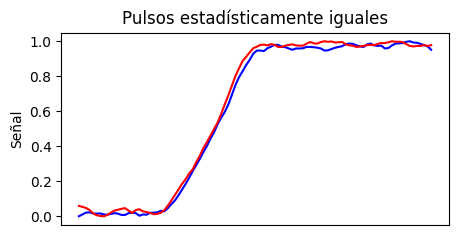

In [113]:
##Representación de un par de pulsos que se obtienen como estadísticamente iguales
x_random = random.randint(0, pares_pulsos_iguales.shape[1])
row_pulses = pares_pulsos_iguales.iloc[x_random]
pulso1_prueba = row_pulses[:100]
pulso2_prueba = row_pulses[-100:]
pulso2_prueba.index = list(range(0, 100))

plt.figure(figsize = (5, 2.5))
plt.plot(pulso1_prueba, label = "Pulso 1", color = "blue")
plt.plot(pulso2_prueba, label = "Pulso 2", color = "red")
plt.title('Pulsos estadísticamente iguales')
plt.xticks([])
plt.ylabel('Señal')
plt.show()